In [409]:
import numpy as np
import pandas as pd
import os

import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
import joblib

import warnings
warnings.filterwarnings('ignore')

color = '\033[1m\033[38;5;208m'
print(f"{color}Versión de las librerias utilizadas:")
print(f"{color}- Version xgboost: {xgb.__version__}")
print(f"{color}- Version pandas: {pd.__version__}")
print(f"{color}- Version numpy: {np.__version__}")


Versión de las librerias utilizadas:
- Version xgboost: 3.0.2
- Version pandas: 2.2.3
- Version numpy: 1.26.4


In [410]:
num_sample_per_class = 1000

In [411]:
try:
    data = pd.read_csv('../Datasets/dataset_original.csv') 
    print("Dataset original cargado correctamente.")
except Exception as e:
    print(f"Error: {e}")

try:
    data_gen = pd.read_csv('../Datasets/dataset_Gen.csv')  
    print("Dataset generado cargado correctamente.")
except Exception as e:
    print(f"Error: {e}")


Dataset original cargado correctamente.
Dataset generado cargado correctamente.


In [412]:
data['gender'] = data['gender'].astype(str).str.strip().str.upper()

def recategorize_smoking(smoking_status):
    if smoking_status in ['never', 'No Info']:
        return 'non-smoker'
    elif smoking_status == 'current':
        return 'current'
    elif smoking_status in ['ever', 'former', 'not current']:
        return 'past_smoker'

data['smoking_history'] = data['smoking_history'].apply(recategorize_smoking)

data = pd.get_dummies(data, columns=['gender', 'smoking_history'], drop_first=True)
data.dropna(inplace=True)
data.columns = data.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)

print("Preprocesamiento dataset original listo.")
data_sample = data


Preprocesamiento dataset original listo.


In [413]:
data_gen['gender'] = data_gen['gender'].astype(str).str.strip().str.upper()
data_gen['smoking_history'] = data_gen['smoking_history'].apply(recategorize_smoking)

data_gen = pd.get_dummies(data_gen, columns=['gender', 'smoking_history'], drop_first=True)
data_gen.dropna(inplace=True)
data_gen.columns = data_gen.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)

print("Preprocesamiento dataset generado listo.")
data_gen_sample = data_gen


Preprocesamiento dataset generado listo.


In [414]:
data.info()
data_gen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   age                          100000 non-null  float64
 1   hypertension                 100000 non-null  int64  
 2   heart_disease                100000 non-null  int64  
 3   bmi                          100000 non-null  float64
 4   HbA1c_level                  100000 non-null  float64
 5   blood_glucose_level          100000 non-null  int64  
 6   diabetes                     100000 non-null  int64  
 7   gender_MALE                  100000 non-null  bool   
 8   gender_OTHER                 100000 non-null  bool   
 9   smoking_history_nonsmoker    100000 non-null  bool   
 10  smoking_history_past_smoker  100000 non-null  bool   
dtypes: bool(4), float64(3), int64(4)
memory usage: 5.7 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries

In [415]:
# Completar datos faltantes
data_count = data['diabetes'].value_counts()
print(f"Dataset original: {data_count}")

# Calcular cuánto necesitamos de cada clase
needed_0 = max(0, num_sample_per_class - data_count[0])
needed_1 = max(0, num_sample_per_class - data_count[1])

# Siempre crear las variables, aunque sea con 0 muestras
if needed_0 > 0:
    class_0 = data_gen[data_gen['diabetes'] == 0].sample(n=needed_0, random_state=42)
else:
    class_0 = pd.DataFrame(columns=data_gen.columns)  # DataFrame vacío pero con columnas

if needed_1 > 0:
    class_1 = data_gen[data_gen['diabetes'] == 1].sample(n=needed_1, random_state=42)
else:
    class_1 = pd.DataFrame(columns=data_gen.columns)  # DataFrame vacío pero con columnas

print(f"Clase 0: {len(class_0)} muestras adicionales")
print(f"Clase 1: {len(class_1)} muestras adicionales")

Dataset original: diabetes
0    91500
1     8500
Name: count, dtype: int64
Clase 0: 0 muestras adicionales
Clase 1: 0 muestras adicionales


In [416]:
# Solo concatenar si hay datos que agregar
dataframes_to_concat = [df for df in [class_0, class_1] if not df.empty]

if dataframes_to_concat:
    balanced_train_data_gen = pd.concat(dataframes_to_concat).sample(frac=1, random_state=42).reset_index(drop=True)
    print("--- Distribución de clases completadas ---")
    print(balanced_train_data_gen['diabetes'].value_counts())
    data_gen_sample = balanced_train_data_gen
else:
    print("No se necesitan datos adicionales del dataset generado")
    data_gen_sample = pd.DataFrame()  # DataFrame vacío

No se necesitan datos adicionales del dataset generado


In [417]:
# Limitar dataset original a num_sample_per_class por clase
data_sample_limited = pd.concat([
    data[data['diabetes'] == 0].sample(n=num_sample_per_class, random_state=42),
    data[data['diabetes'] == 1].sample(n=min(num_sample_per_class, len(data[data['diabetes'] == 1])), random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Dataset original limitado: {data_sample_limited['diabetes'].value_counts()}")

x = data_sample_limited.drop(columns=["diabetes"]).to_numpy()
y = data_sample_limited["diabetes"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42, stratify=y_train)

# Verificar si hay datos generados
if not data_gen_sample.empty:
    x_gen = data_gen_sample.drop(columns=["diabetes"]).to_numpy() 
    y_gen = data_gen_sample["diabetes"].to_numpy()
    
    X_gen_train, X_gen_test, y_gen_train, y_gen_test = train_test_split(x_gen, y_gen, test_size=0.20, random_state=42, stratify=y_gen)
    X_gen_train, X_gen_val, y_gen_train, y_gen_val = train_test_split(X_gen_train, y_gen_train, test_size=0.15, random_state=42, stratify=y_gen_train)
else:
    # Si no hay datos generados, usar arrays vacíos
    X_gen_train, X_gen_test = np.array([]).reshape(0, x.shape[1]), np.array([]).reshape(0, x.shape[1])
    y_gen_train, y_gen_test = np.array([]), np.array([])
    X_gen_val, y_gen_val = np.array([]).reshape(0, x.shape[1]), np.array([])


Dataset original limitado: diabetes
1    1000
0    1000
Name: count, dtype: int64


In [418]:
X_train_orig_pd = pd.DataFrame(X_train)
y_train_orig_pd = pd.Series(y_train)
X_test_orig_pd = pd.DataFrame(X_test)
y_test_orig_pd = pd.Series(y_test)

X_gen_train_pd = pd.DataFrame(X_gen_train)
y_gen_train_pd = pd.Series(y_gen_train)
X_gen_test_pd = pd.DataFrame(X_gen_test)
y_gen_test_pd = pd.Series(y_gen_test)

X_train = (pd.concat([X_gen_train_pd, X_train_orig_pd]).sample(frac=1, random_state=42).reset_index(drop=True)).to_numpy()
y_train = (pd.concat([y_gen_train_pd, y_train_orig_pd]).sample(frac=1, random_state=42).reset_index(drop=True)).to_numpy()

X_test = (pd.concat([X_gen_test_pd, X_test_orig_pd]).sample(frac=1, random_state=42).reset_index(drop=True)).to_numpy()
y_test = (pd.concat([y_gen_test_pd, y_test_orig_pd]).sample(frac=1, random_state=42).reset_index(drop=True)).to_numpy()

print(f"Datos finales - Train: {len(X_train)}, Test: {len(X_test)}")


Datos finales - Train: 1360, Test: 400


In [419]:
clf = xgb.XGBClassifier()

In [420]:
param_grid = {
    'n_estimators': [100],
    'max_depth': [3],
    'learning_rate': [0.001, 0.01],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

In [421]:
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


In [422]:
model_dir = f'../Guardar_modelo/Test/Binary/'
os.makedirs(model_dir, exist_ok=True)

model_path = f'{model_dir}Binary_{num_sample_per_class}_xgboost.pkl'
joblib.dump(grid_search.best_estimator_, model_path)


['../Guardar_modelo/Test/Binary/Binary_1000_xgboost.pkl']

In [423]:
y_pred = grid_search.predict(X_test)


Model Accuracy: 0.8975
              precision    recall  f1-score   support

No Diabético       0.86      0.95      0.90       200
   Diabético       0.95      0.84      0.89       200

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400



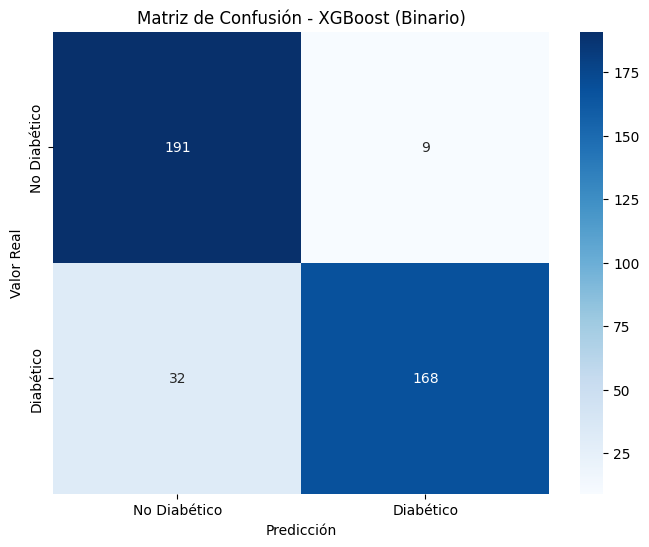

In [424]:
print('Model Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['No Diabético', 'Diabético']))

cm = confusion_matrix(y_test, y_pred)
class_names = ['No Diabético', 'Diabético']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión - XGBoost (Binario)')
plt.show()